# Handwritten Digit Recognition using Two-Layer Feedforward Neural Networks in TensorFlow with Keras

In [1]:
import os
from time import time
from datetime import datetime, timedelta, timezone
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

MNISTの手書き数字画像の特徴量は、28×28の2次元配列だ。その全ての行をつなげて1行にする。こうしてできた1次元配列(28×28=784次元ベクトル)を、ニューラルネットワークの各入力とする。

In [3]:
img_rows, img_cols = 28, 28
input_dim = img_rows * img_cols # = 784

In [4]:
X_train = X_train.reshape(-1, input_dim).astype('float32') / 255
X_test = X_test.reshape(-1, input_dim).astype('float32') / 255

入力の各要素(8ビットの非負整数値)を255(=2^8-1)で割ることで、0〜1に正規化している。

In [5]:
X_train.shape

(60000, 784)

In [6]:
# X_train[0]

各出力は10次元ベクトルとする。そのベクトルの各次元は、分類されるクラスに対応している。今回は[0..9]の整数だ。

In [7]:
output_dim = 10

ラベルは、あらかじめ10次元ベクトルに変換しておく。該当クラスの要素だけ1で、他の要素は0にする。この表現方法はone-hotエンコーディング(OHE)と呼ばれる。

In [8]:
Y_train = np_utils.to_categorical(y_train.astype('int32'), output_dim) 
Y_test = np_utils.to_categorical(y_test.astype('int32'), output_dim)

In [9]:
Y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

中間層(隠れ層)のユニット数(ニューロン数)を16とする。ユニット数を増やせば正解率(accuracy)が上がるが、学習に時間がかかる。また、パラメータの数が増えて過学習が起きやすくなる。

In [10]:
UNITS = 16
# UNITS = 128
# UNITS = 512

中間層の活性化関数にはSigmoidを使う。これをReLUに変えるだけでも、正解率が上がることを確認しておく。ReLUの方が学習にかかる時間も短くなる。

In [11]:
ACTIVATION = 'sigmoid'
# ACTIVATION = 'relu'

最適化アルゴリズムにはAdamを使う。

In [12]:
# OPTIMIZER = 'sgd'
# OPTIMIZER = 'rmsprop'
OPTIMIZER = 'adam'

また、ミニバッチ学習を行う。つまり、ランダムに選択したトレーニングデータの一部(ミニバッチ)を用いた学習(パラメータ更新)を繰り返す。今回、ミニバッチのサイズ(batch_size)を128とする。

In [13]:
BATCH_SIZE = 128

トレーニングデータが60,000個だとすると、60,000 / 128 = 468.75なので、468回のパラメータ更新で、データを全て使ったとみなすことができる。この1サイクルのことをエポックという。

今回のように、トレーニングデータ数がバッチサイズで割り切れない場合、実際には、使われずに残るデータがある。さらに、ランダムに選択するがゆえに選択されずに残るデータもある。それでも、(トレーニングデータ数 / バッチサイズ)の小数点以下を切り捨てた整数を、1エポックのイテレーション数とする。

今回、エポック数は300とする。

In [14]:
EPOCHS = 300

最後までいけば、468 × 300 = 140,400回のパラメータ更新が行われる。

しかし、学習すればするほど正答率が上がる訳ではない。トレーニングデータに適合し過ぎて、未知データに適合できなくなることがある。これは、オーバーフィッティング(過学習)と呼ばれる。

最適なエポック数を試行錯誤で見つけてもいいが、early stoppingを使うことにする。つまり、クロスエントロピー誤差がほとんど変わらなくなった時点で、学習を終了させる。

この検証時に使われるデータは、バリデーションデータと呼ばれる。バリデーションデータを用意するために、Kerasでは、model.fitの引数validation_splitを渡す。

今回は、

In [15]:
VALIDATION_SPLIT = 0.1

としておく。すると、自動的にトレーニングデータの10%をバリデーションデータとして使ってくれる。バリデーションデータをよけておくので、トレーニングデータは、実際には60,000個より少なくなる。

バリデーションデータは、自分でトレーニングデータから一部をよけておいてもいい。この場合、model.fitの引数validation_dataに、そのデータを渡すことになる。

validation_dataにテストデータを渡しているソースコードもあるが、本当は良くない。テストの時に、実際よりも高い正答率が出てしまう。テストデータを使ってチューニングをするのだから、当然そうなる。テストデータは、最後にパフォーマンスを見るためだけにとっておく。

では、2層のニューラルネットワークを作る。中間層が1層と出力層が1層の構成だ。入力層は、実質的には中間層の1層目に対する入力なので、実装上は出現しない。

In [16]:
model = Sequential()
model.add(Dense(UNITS, activation=ACTIVATION, input_dim=input_dim))
model.add(Dense(output_dim, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=OPTIMIZER,
             metrics=['accuracy'])

ログを出すには、verbose=1とする。TensorBoardを作成するためのコールバックも用意しておく。

In [17]:
VERBOSE = 1
# VERBOSE = 0

def make_tensorboard(log_dir_base):
    jst = timezone(timedelta(hours=+9), 'JST')
    jst_now = datetime.now(jst)
    log_dir = log_dir_base + '_' + jst_now.strftime('%Y%m%d%H%M%S')
    os.makedirs(log_dir, exist_ok=True)
    tensorboard = TensorBoard(log_dir=log_dir)
    return tensorboard

CALLBACKS = [
    EarlyStopping(patience=0, verbose=1),
    make_tensorboard(log_dir_base='log/tlffnn_keras_mnist')
]

実行時間を計測しながら、学習させる。

In [18]:
start_time = time()

history = model.fit(X_train,
                    Y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=CALLBACKS)

print('Executed in {0:.3f}s'.format(time() - start_time))

Train on 54000 samples, validate on 6000 samples
Epoch 1/300
54000/54000 [==============================] - 2s 33us/step - loss: 1.2942 - acc: 0.7459 - val_loss: 0.7351 - val_acc: 0.8915
Epoch 2/300
54000/54000 [==============================] - 1s 23us/step - loss: 0.6161 - acc: 0.8816 - val_loss: 0.4281 - val_acc: 0.9170
Epoch 3/300
54000/54000 [==============================] - 1s 22us/step - loss: 0.4317 - acc: 0.9017 - val_loss: 0.3255 - val_acc: 0.9275
Epoch 4/300
54000/54000 [==============================] - 1s 18us/step - loss: 0.3563 - acc: 0.9121 - val_loss: 0.2774 - val_acc: 0.9337
Epoch 5/300
54000/54000 [==============================] - 1s 18us/step - loss: 0.3156 - acc: 0.9181 - val_loss: 0.2500 - val_acc: 0.9358
Epoch 6/300
54000/54000 [==============================] - 1s 17us/step - loss: 0.2891 - acc: 0.9238 - val_loss: 0.2315 - val_acc: 0.9392
Epoch 7/300
54000/54000 [==============================] - 1s 17us/step - loss: 0.2699 - acc: 0.9275 - val_loss: 0.2181 - v

学習曲線を見て、オーバーフィッティングが起きていないか確認する。

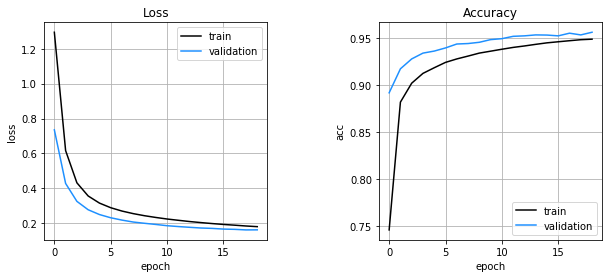

In [19]:
plt.figure(1, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train', color='black')
plt.plot(history.history['val_loss'], label='validation', color='dodgerblue')
plt.legend()
# plt.ylim(0, 10)
plt.grid()
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='train', color='black')
plt.plot(history.history['val_acc'], label='validation', color='dodgerblue')
plt.legend(loc='lower right')
# plt.ylim(0, 1)
plt.grid()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')

plt.show()

テストデータを使って結果を確認する。

In [20]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

10000/10000 [==============================] - 0s 22us/step
Test loss:  0.20192676213681698
Test accuracy:  0.9388


正解率を出すだけではなく、最初の50個の具体的な結果も出す。画像の上に予測を表示し、間違えている場合は括弧つきで正解も表示する。背景色を赤にすることで、間違いを見つけやすくしておく。

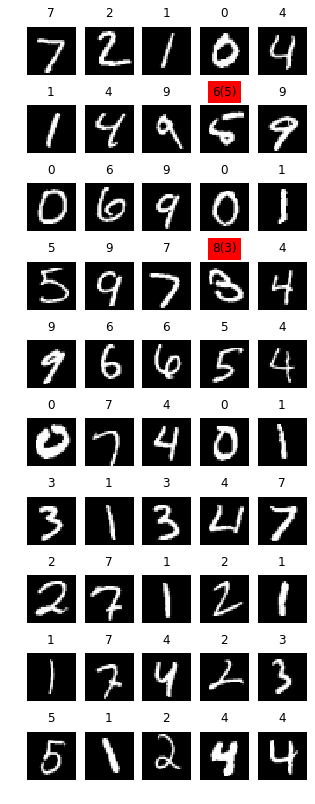

In [21]:
TEST_COUNT = 50

Y_predict = model.predict(X_test)

plt.figure(1, figsize=(5, 14))
plt.subplots_adjust(hspace=0.4)

for i in range(TEST_COUNT):
    plt.subplot(10, 5, i + 1)
    X = X_test[i, :].reshape(28, 28)
    Y = Y_predict[i, :]
    prediction = np.argmax(Y)
    y = np.argmax(Y_test[i, :])
    if prediction == y:
        plt.title(prediction, pad=10)
    else:
        plt.title('{}({})'.format(prediction, y), pad=10,
                  backgroundcolor='red')
    plt.axis('off')
    plt.imshow(X, cmap='gray') 

plt.show()

最後に、パラメータ(weights)を視覚化しておくのも面白い。

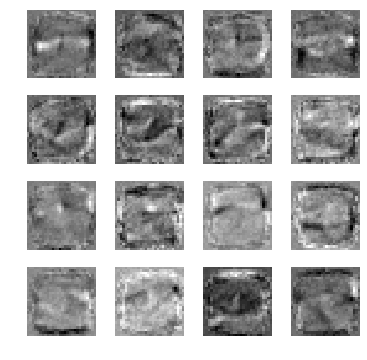

In [22]:
weights = model.layers[0].get_weights()[0]

columns = 4
rows = math.ceil(UNITS / columns)
plt.figure(1, figsize=(columns * 1.5, rows * 1.5))
plt.subplots_adjust(wspace=0.25, hspace=0.25)

for i in range(weights.shape[-1]):
    plt.subplot(rows, columns, i + 1)
    w = weights[:, i].reshape(img_rows, img_cols)
    plt.axis('off')
    plt.imshow(w, cmap='gray')
 
plt.show()

白い部分に文字の一部があると、そのユニットは活性し、黒い部分だと抑制する。いくつかは、数字の"2"や"3"の形が浮かび上がっているように見える。それらの数字を認識するのに役立っているのかもしれない。